In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import vector
import pandas as pd
import lhapdf
import itertools
import functools

## General code for calculating polarization vector

In [2]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
  
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    # DUNE paper eq 10, 11, 12
    F = (
        (2*W1 + mtau**2/M**2 * W4) * (Etau - ptau * costheta) + W2 * (Etau + ptau * costheta) - W5 * mtau**2 / M
        # Only difference with tau polarization paper is that it is -W3 instead of +W3
        - W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
    )

    return (
        # P_T. Only difference with tau polarization paper is that it is -W3 instead of +W3
        -mtau * np.sin(theta) * (2*W1 - W2 - mtau**2 / M**2 * W4 + W5 * Etau / M - W3 * Enu / M) / F,
        # P_L
        -(
            (2*W1 - mtau**2/M**2 * W4) * (ptau - Etau * costheta) + W2 * (ptau + Etau * costheta) - W5 * mtau**2 / M * costheta
            # Only difference with tau polarization paper is that it is -W3 instead of +W3
            - W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
        ) / F
    )

    # R = (
    #     (Etau - ptau * costheta) / M * (W1 + mtau**2 / (2*M**2)*W4)
    #     + (Etau + ptau * costheta) / (2*M) * W2
    #     + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
    #     - mtau**2 / (2*M**2) * W5
    # )

    # return (
    #     # P_P component, in the tau-nu plane
    #     mtau * np.sin(theta) / (2*M*R) * (
    #         -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
    #     ),
    #     # P_L component
    #     -1 + mtau**2/(M**2 * R) * (
    #         (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
    #         + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
    #     ),
    # )


def spin_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "res_sig":
        # This is the signed Pmag, where -1 < Pmag < 1
        Pmag = (pdfvalues["sigpp"] - pdfvalues["sigmm"]) / (pdfvalues["sigpp"] + pdfvalues["sigmm"]).values / 2
        Pmag[np.isnan(Pmag)]
        return (
            # sx. For now, set it to 0. This is not correct but I do not know how to calculate the full polarization vector from the Berger-Sehgal model
            np.zeros(pdfvalues.shape[0]), 
            # sz. In reality, this is actually the polarization magnitude P
            (pdfvalues["sigpp"] - pdfvalues["sigmm"]) / (pdfvalues["sigpp"] + pdfvalues["sigmm"]).values / 2
        )
        
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        - mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )

def leptonic_weak_current(sign, mu, Enu, Etau, theta, ptau):
    if sign > 0:
        return np.sqrt(2*Enu*(Etau - ptau)) * [np.sin(theta/2), -np.cos(theta/2), 1j*np.cos(theta/2), np.sin(theta/2)][mu]
    return np.sqrt(2*Enu*(Etau + ptau)) * [np.cos(theta/2), np.sin(theta/2), -1j*np.sin(theta/2), np.cos(theta/2)][mu]

def leptonic_tensor(sign1, sign2, mu, nu, Enu, Etau, theta, ptau):
    return leptonic_weak_current(sign1, mu, Enu, Etau, theta, ptau) * np.conj(leptonic_weak_current(sign2, nu, Enu, Etau, theta, ptau))

#An antisymmetric tensor where epsilon(0, 1, 2, 3) = 1
@functools.cache
def epsilon_tensor(i, j, k, l):
    indices = [i, j, k, l]
    if len(set(indices)) != 4:
        return 0  # If any indices are repeated, the result is zero
    permutation = [0, 1, 2, 3]
    sign = 1
    for p in range(4):
        for q in range(p+1, 4):
            if indices[permutation[p]] > indices[permutation[q]]:
                sign *= -1
    return sign

metric_tensor = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

index2name = ["t", "x", "y", "z"]

def hadronic_tensor(mu, nu, W1, W2, W3, W4, W5, p, q, M):
    # assert q[index2name[mu]].shape == W1.shape

    return (
        -metric_tensor[mu, nu] * W1
        + p[index2name[mu]] * p[index2name[nu]] / M**2 * W2 
        - 1j*np.sum([
            epsilon_tensor(mu, nu, alpha, beta) * p[index2name[alpha]] * q[index2name[beta]] / (2*M**2) * W3
            for alpha, beta in itertools.product(range(4), repeat=2)
        ], axis=0)
        + q[index2name[mu]] * q[index2name[nu]] / M**2 * W4
        + (p[index2name[mu]] * q[index2name[nu]] + q[index2name[mu]] * p[index2name[nu]]) / (2*M**2) * W5
    )

def R(sign1: int, sign2: int, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M):
    return np.sum([
        leptonic_tensor(sign1, sign2, mu, nu, Enu, Etau, theta, ptau) * hadronic_tensor(mu, nu, W1, W2, W3, W4, W5, p, q, M)
        for mu, nu in itertools.product(range(4), repeat=2)
    ], axis=0)

def spin_vector2(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")

    Rpp = R(1, 1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rmm = R(-1, -1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rpm = R(1, -1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    Rmp = R(-1, 1, W1, W2, W3, W4, W5, Enu, Etau, theta, ptau, p, q, M)
    
    assert np.allclose(Rmp.imag, -Rpm.imag), (Rmp, Rpm)
    # assert np.allclose(Rmp.imag, 0) This should be true in reality
    assert np.allclose(Rpm.real, Rmp.real)
    assert np.allclose(Rmm.imag, 0)
    assert np.allclose(Rpp.imag, 0)
    
    return (
        # sx component, in the tau-nu plane
        np.real((Rpm + Rmp) / (Rpp + Rmm) / 2),
        # sz component
        np.real((Rpp - Rmm) / (Rpp + Rmm) / 2)
    )

In [3]:
def boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=False, rotate_tau=True):
    """Change reference frame to one where the nucleon is at rest, the neutrino has a pure momentum in the +z direction, and the tau only has a momentum in the x and z directions.
    
    These are the three assumptions that exist for the formula to work. 
    The third assumption is most likely taken care for in the formulas automatically, since all formulas either use p*q, q**2 or some other parameter where the """
    # Replace the nucleon 4-momentum vectors that are incorrect
    # zero_nucleons = nucleon4m.E == 0
    assert not np.any(nucleon4m.E == 0)
    # nucleon_arr = np.array([nucleon4m.E, nucleon4m.px, nucleon4m.py, nucleon4m.pz])
    # nucleon_arr[0, zero_nucleons] = 0.98318
    # nucleon4m = vector.array({"E": nucleon_arr[0, :], "px": nucleon_arr[1, :], "py": nucleon_arr[2, :], "pz": nucleon_arr[3, :]})

    # Boost all vectors such that the nucleon is at rest
    tau4m_boosted = tau4m.boostCM_of(nucleon4m)
    nucleon4m_boosted = nucleon4m.boostCM_of(nucleon4m)
    nutau4m_boosted = nutau4m.boostCM_of(nucleon4m)

    # get the angles to rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    phi = nutau4m_boosted.phi
    theta = nutau4m_boosted.theta

    # Rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    nutau4m_rotated = nutau4m_boosted.rotateZ(-phi).rotateY(-theta)
    # Rotate all other momentum vectors, thereby preserving the 4-momentum conservation
    tau4m_rotated = tau4m_boosted.rotateZ(-phi).rotateY(-theta)
    nucleon4m_rotated = nucleon4m_boosted.rotateZ(-phi).rotateY(-theta)
    
    if not rotate_tau:
        return nutau4m_rotated, nucleon4m_rotated, tau4m_rotated
    
    tau_phi = tau4m_rotated.phi
    # Rotate nutau4m_boosted so that it is aligned with the z axis, pointing towards positive z
    nutau4m_rotated2 = nutau4m_rotated.rotateZ(-tau_phi)
    # Rotate all other momentum vectors, thereby preserving the 4-momentum conservation
    tau4m_rotated2 = tau4m_rotated.rotateZ(-tau_phi)
    nucleon4m_rotated2 = nucleon4m_rotated.rotateZ(-tau_phi)

    if test:
        assert np.allclose(nucleon4m_boosted.px, 0), nucleon4m_boosted.px[~np.isclose(nucleon4m_boosted.px, 0)]
        assert np.allclose(nucleon4m_boosted.py, 0), nucleon4m_boosted.py[~np.isclose(nucleon4m_boosted.py, 0)]
        assert np.allclose(nucleon4m_boosted.pz, 0), nucleon4m_boosted.py[~np.isclose(nucleon4m_boosted.py, 0)]

        assert np.allclose(nutau4m_rotated.px, 0), nutau4m_rotated.px[~np.isclose(nutau4m_rotated.px, 0)]
        assert np.allclose(nutau4m_rotated.py, 0), nutau4m_rotated.py[~np.isclose(nutau4m_rotated.py, 0)]
        assert np.allclose(nutau4m_rotated.E, nutau4m_rotated.pz), nutau4m_rotated[~np.isclose(nutau4m_rotated.pz, nutau4m_rotated.E)]

        assert np.allclose(nucleon4m_rotated.px, 0)
        assert np.allclose(nucleon4m_rotated.py, 0)
        assert np.allclose(nucleon4m_rotated.pz, 0)

        assert np.allclose(tau4m_rotated2.py, 0), (tau4m_rotated2.py, tau4m_rotated.py)
        assert np.all(nutau4m_rotated2.isclose(nutau4m_rotated))
        assert np.all(nucleon4m_rotated2.isclose(nucleon4m_rotated))
        
        # Q^2
        assert np.allclose(-(nutau4m_rotated - tau4m_rotated)**2, -(nutau4m - tau4m)**2)
    
    return nutau4m_rotated2, nucleon4m_rotated2, tau4m_rotated2

In [4]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V_qel = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi_qel = 3.706
# 
M_A_qel = 1 # GeV
#
F_A_0_qel = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V_qel**2)**2

def G_V_M(q):
    return (1+xi_qel) / (1-q**2/M_V_qel**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_E(q)) / (xi_qel * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0_qel / (1 - q**2 / M_A_qel**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def W2qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2))
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M))))
        + W2qel(x, Q2, p, q, M)
    )

In [5]:
# Resonance scattering
# Delta mass
M_delta_res = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_Delta_0_res = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# This should not matter, as it is multiplied to all values and then divided away
kappa_res = 2/3
M_V_res = 0.84 # GeV. Maybe 0.84 GeV, see GiBUU thesis eq 5.24
C_V_3_0_res = 1.95 # Maybe 1.95, see GiBUU thesis eq 5.24

C_A_5_0_res = 1.2 # GiBUU thesis eq 5.27
C_0_res = {4: -0.3, 5: 1.2}
a_coeff_res = -1.21
b_coeff_res = 2 # GeV^2
M_A_res = 1.05 # GeV


def K(zeta, x, w, j, k, n):
    functions = {
        (3, 3, 3): lambda zeta, x, w: -2 * zeta**3 * (1 - 2*x)**2 * w**2 + 2 * zeta * (2 - 3*x) * w,
        (3, 3, 4): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (3, 3, 5): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w + 2 * (1 + zeta),
        (3, 4, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 - zeta) * (1 - 2*x) * w,
        (3, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**2,
        (3, 4, 5): lambda zeta, x, w: zeta * (1 - 2*x) * w,
        (3, 5, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w**2 - 2 * (1 - zeta) * w,
        (3, 5, 4): lambda zeta, x, w: zeta * (1 - 2*x) * w**2,
        (3, 5, 5): lambda zeta, x, w: zeta * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def A(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 - 2 * (1 - zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**2 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * w,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 + (1 + zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (1, 5, 5): lambda zeta, x, w: zeta * w + 1 + zeta,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 + zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 + 2 * (1 + zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w + 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 + 2 * zeta * (2 + zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w + zeta * (2 + zeta),
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 + zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 + 2 * (1 + zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 - 2 * (1 + zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta * (zeta * (1 + zeta) * (1 - 2*x) - 1) * w - 2 * (1 + zeta),
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (zeta * (1 + zeta) * (1 - 2*x)**2 + 2 * x) * w**2 + 2 * (1 + zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 + zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + x) * w + (1 + zeta)**2,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 + zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 + 2 * (1 + zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 - 4 * (1 + zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 2 * zeta**3 * w + 2 * zeta**2 * (1 + zeta),
        (5, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta**2 * (1 + zeta) * (1 - 2*x) * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)


def V(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 + 2 * (1 + zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * w**2,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 - (1 - zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**3 - (1 - zeta) * (1 - 4*x) * w**2,
        (1, 5, 5): lambda zeta, x, w: zeta * w**3 - (1 - zeta) * w**2,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 - 2 * (1 - zeta) * x * w,
        (2, 4, 5): lambda zeta, x, w: 4 * zeta * x * w**2 - 4 * (1 - zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x**2 * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * x * w**2 - 2 * (1 - zeta) * x * w,
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w - 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 - 2 * zeta * (2 - zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w**2 - zeta * (2 - zeta) * w,
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 - zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 - 2 * (1 - zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 + 2 * (1 - zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w**3 - zeta**2 * (1 - zeta) * w**2,
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**3 - 2 * zeta * (1 + zeta * (1 - zeta) * (1 - 2*x)) * w**2 + 2 * (1 - zeta) * w,
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 - zeta * (zeta * (1 - zeta) * (1 - 2*x)**2 - 2*x) * w**2 - 2 * (1 - zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 - zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 4 * zeta * w**2 - 4 * (1 - zeta) * w,
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 + 4 * (1 - zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * w**2 - 2 * (1 - zeta) * w,
        (5, 5, 6): lambda zeta, x, w: 4 * zeta**3 * (1 - 2*x) * x * w**3 - 4 * zeta * (zeta * (1 - zeta) * (1 - 2*x) + 1) * x * w**2 + 4 * (1 - zeta) * x * w,
    }

    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def C_V(q, W, M, j):
    if j == 3:
        # GiBUU thesis eq 5.24
        return C_V_3_0_res / (1 - q**2 / M_V_res**2)**2 / (1 - q**2 / (4*M_V_res**2))
    elif j == 4:
        # GiBUU thesis eq 5.23
        return - M / W * C_V(q, W, M, 3)
    elif j in {5, 6}:
        return np.zeros(q.shape)
    else:
        raise ValueError(f"Unsupported j = {j}")
    
def C_A(q, M, j):
    # Might also be different. See GiBUU thesis eq 5.28 - 5.30
    if j == 3:
        return np.zeros(q.shape)
    elif j == 6:
        return C_A(q, M, 5) * M**2 / (m_pi**2 - q**2)
    elif j == 5:
        return C_A_5_0_res / (1 - q**2 / M_A_res**2)**2 / (1 - q**2 / (3 * M_A_res**2))
    elif j == 4:
        return -C_A(q, M, 5) / 4
    else:
        raise ValueError(f"Unsupported j = {j}")

# def G_A_RS(q, M, j):
#     # TODO. See Rein-Seghal paper
#     (1-q**2 / (2*m))

def p_pi_star(W, M):
    return np.sqrt(((W**2 - M**2 + m_pi**2)/(2*W))**2 - m_pi**2)

def lambda_func(a, b, c):
    return a**2 + b**2 + c**2 - 2*(a*b + a*c + b*c)

def q_CM(W, M):
    q = (W**2 - m_pi**2 - M**2)**2 - 4*m_pi**2 * M**2
    q[q < 0] = 1
    return np.sqrt(q) / (2*W)

def Gamma_Delta(W, M):
    # NOTE according to GiBUU thesis, P-wave is more correct, as it preserves angular momentum, which S-waves do not. 
    #  This should however not affect my results, as this constant is divided away anyway.
    return Gamma_Delta_0_res * (q_CM(W, M) / q_CM(M_delta_res, M))**3
    
    # From tau polarization paper
    # return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))
    
    # From lepton polarization paper, assuming S-waves (L=0).
    # return Gamma_Delta_0_res * (p_pi_star(W, M) / p_pi_star(M_delta_res, M))**3
    # Both of these seem to give the same result

def eta_delta_bw2(W, M, Gamma_Delta_f=Gamma_Delta):
    value = 1/(2*np.pi) * Gamma_Delta_f(W, M) / ((W**2 - M_delta_res**2)**2 + Gamma_Delta_f(W, M)**2 / 4)
    # If a nan value is encountered, set to 1 to not make the whole computation into nan. 
    # This is ok, because this value does not affect the final polarization anyway.
    value[np.isnan(value)] = 1
    return value

def Wnres(x, Q2, p, q, M, n, W):
    # The invariant mass of the Delta particle. 
    # This should be a sample from a Breit-Wigner distribution 
    # around the central mass M_Delta and with width Gamma_Delta
    # W = np.sqrt((p + q)**2)

    w_value = w(p, q, M)
    # x = Q2 / (2*p.dot(q))
    zeta = M / M_delta_res
    
    # Since the constants are the same for all Wnres terms, they will not affect the value of the polarization, as they are divided away. This means that 
    # kappa_res * np.cos(theta_c)**2 * M * M_delta_res * eta_delta_bw2(W, M) is meaningless. 
    # if n == 3:
    #     return (
    #         2 * kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
    #         eta_delta_bw2(W, M) * 
    #         np.sum(
    #             [K(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_A(q, M, k)
    #             for j, k in itertools.product(range(3, 7), repeat=2)],
    #             axis=0
    #         )
    #     )
    
    return (
        kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
        eta_delta_bw2(W, M) * 
        np.sum([
            # V and A only have non-zero values for n != 3
            V(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_V(q, W, M, k) 
            + A(zeta, x, w_value, j, k, n) * C_A(q, M, j) * C_A(q, M, k)
            # K only has non-zero values for n == 3
            + 2*K(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_A(q, M, k)
            for j, k in itertools.product(range(3, 7), repeat=2)],
            axis=0
        )
    )

In [6]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
pdfset = lhapdf.mkPDF("CT10nlo", 0)
def pdf(quark, x, Q2):
    # Division by x might be wrong.
    # Probably does not have an effect on the result, since all PDFs are divided by the value
    f = pdfset.xfxQ2(quark, x, Q2) / x
    return np.array(f)


def mass_corrected_xi(x, Q2, charm):
    xi = x.copy()
    m_charm = 1.27 # GeV
    # If a charm quark is produced, replace x with xi
    xi[charm] = x[charm] / (Q2[charm] / (Q2[charm] + m_charm**2))
    # Cap the x to 1
    # xi[xi > 1] = 1
    # print(xi)
    return xi

def W1dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdf(quark, xi, Q2) for quark in range(1, 7)], axis=0)
        - np.sum([pdf(quark, xi, Q2) for quark in range(-6, 0)], axis=0)
    )

def W4dis_pdf(x, Q2, p, q, M, charm):
    return 0

def W5dis_pdf(x, Q2, p, q, M, charm):
    # In the tau polarization paper, there is a factor of 2 in front. 
    xi = mass_corrected_xi(x, Q2, charm)
    
    # I am not sure if this is a mistake, convention difference, or something else
    return 1/w(p, q, M) * 2 * np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


LHAPDF 6.5.4 loading /home/simon/miniconda3/envs/cern-skhep/share/LHAPDF/CT10nlo/CT10nlo_0000.dat
CT10nlo PDF set, member #0, version 4; LHAPDF ID = 11000


In [7]:
def W1dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdfvalues[quark] / x for quark in range(1, 7)], axis=0)
        - np.sum([pdfvalues[quark] / x for quark in range(-6, 0)], axis=0)
    )

def W4dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    return 0

def W5dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    
    return 1/w(p, q, M) * 2 * np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


In [8]:
def Wndis_f(x, Q2, p, q, M, charm, pdfvalues, n):
    if n == 1:
        xi = mass_corrected_xi(x, Q2, charm)
        return (1+xi/w(p, q, M)) * pdfvalues[f"F{n}"].values

    return 1/w(p, q, M) * pdfvalues[f"F{n}"].values

In [9]:
def get_pdf_values(dis_events):
    pdfvalues = {}

    assert dis_events.loc[:, "fuv":"fc"].notnull().all().all()

    pdfvalues["event_num"] = dis_events["event_num"]
    # down-quark
    pdfvalues[1] = (dis_events["fdv"] + dis_events["fds"]).values
    # up-quark
    pdfvalues[2] = (dis_events["fuv"] + dis_events["fus"]).values
    # strange-quark
    pdfvalues[3] = dis_events["fs"].values
    # charm-quark
    pdfvalues[4] = dis_events["fc"].values
    # bottom-quark
    pdfvalues[5] = np.zeros(dis_events.shape[0])
    # top-quark
    pdfvalues[6] = np.zeros(dis_events.shape[0])

    # dbar-quark
    pdfvalues[-1] = dis_events["fds"].values
    # ubar-quark
    pdfvalues[-2] = dis_events["fus"].values
    # sbar-quark
    pdfvalues[-3] = dis_events["fs"].values
    # cbar-quark
    pdfvalues[-4] = dis_events["fc"].values
    # bbar-quark
    pdfvalues[-5] = np.zeros(dis_events.shape[0])
    # tbar-quark
    pdfvalues[-6] = np.zeros(dis_events.shape[0])

    pdfvalues = pd.DataFrame(pdfvalues)

    return pdfvalues

## Tests
Test that the code above for calculating the polarization vector is correct by comparing the results with the expected results in the theory paper.

In [32]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info_sig.csv")

# taus = particle_info[particle_info["pdg"] == 15]
# neutrinos = particle_info.groupby("event_num").nth(1)

# q = neutrinos.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True) - taus.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True)

# Add nucleon mass to the DataFrame
# event_info["Ms"] = -q["E"].values + np.sqrt(event_info["Ws"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)
# event_info["M"] = -q["E"].values + np.sqrt(event_info["W"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)

### Quasi-elastic scattering

In [13]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [14]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

nucleon4m = vector.array({"E": qel_events["En"], "px": qel_events["pxn"], "py": qel_events["pyn"], "pz": qel_events["pzn"]})

In [15]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["xs"],
    W=qel_events.iloc[zero_angle_tau_event]["Ws"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.00104892],
        [-0.47480948]]),
 0.9496212797264878,
 array([-0.99999756]))

In [16]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["x"],
    W=qel_events.iloc[zero_angle_tau_event]["W"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-6.90201325e-04],
        [-9.80602694e-01]]),
 0.9806029367119925,
 array([-0.99999975]))

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [17]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(5.000498804220101, 9.420946604808174)

In [19]:
s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost5deg]), 
    vector.MomentumNumpy4D(nutau4m[almost5deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost5deg]), 
    "qel",
    x=qel_events.iloc[almost5deg]["xs"],
    W=qel_events.iloc[almost5deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.13534101],
        [-0.47459022]]),
 0.9870219209492423,
 array([-0.96166095]))

In [20]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost10deg]), 
    vector.MomentumNumpy4D(nutau4m[almost10deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost10deg]), 
    "qel",
    x=qel_events.iloc[almost10deg]["xs"],
    W=qel_events.iloc[almost10deg]["Ws"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.21414843],
        [-0.45178647]]),
 0.9999411211265159,
 array([-0.90362614]))

### Calculate polarization for all qel events

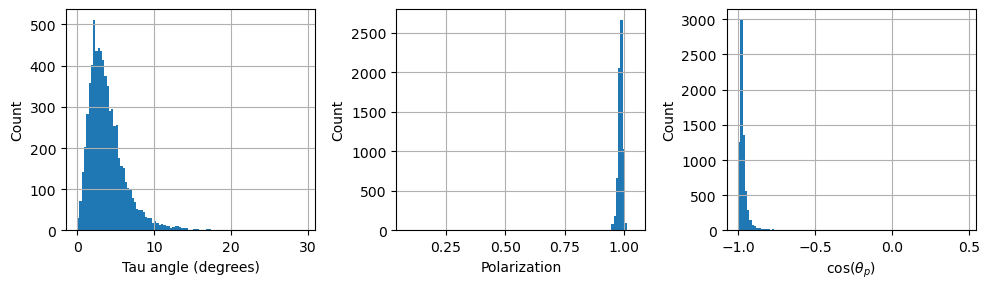

In [21]:
nucleon4m_stationary = vector.array({"E": nucleon4m.M, "px": np.zeros(nucleon4m.shape), "py": np.zeros(nucleon4m.shape), "pz": np.zeros(nucleon4m.shape)})

s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m_stationary, 
    "qel",
    # x=qel_events["x"].values,
    # W=qel_events["W"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

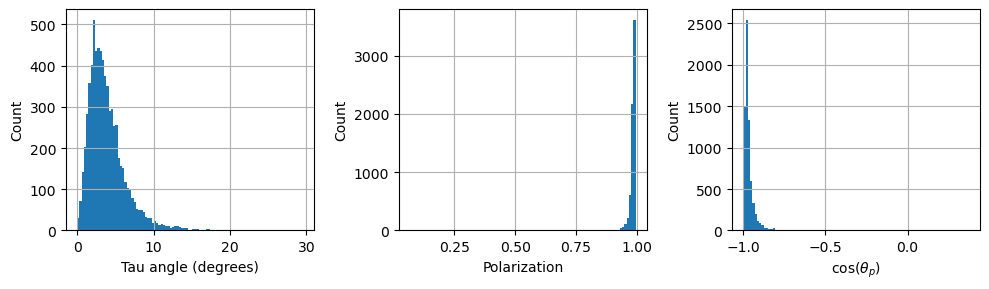

In [22]:
nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

s = np.array(spin_vector(
    tau4m_rotated, 
    nutau4m_rotated, 
    nucleon4m_rotated, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In [23]:
nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, rotate_tau=False)

s2 = np.array(spin_vector(
    tau4m_rotated, 
    nutau4m_rotated, 
    nucleon4m_rotated, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)
assert np.allclose(s, s2)

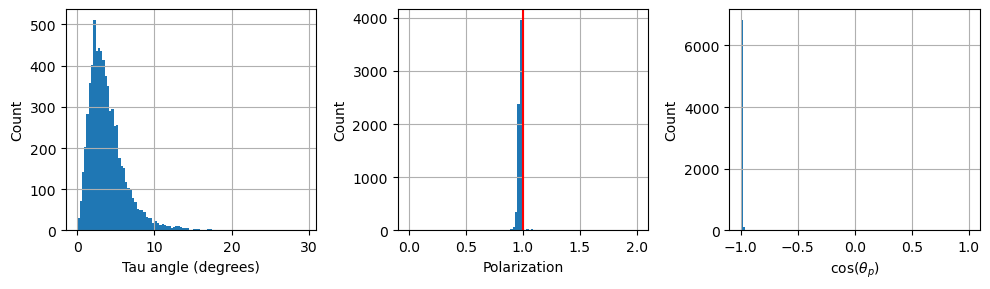

In [24]:
s = np.array(spin_vector2(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=np.linspace(0, 2, 100))
axs[1].set(xlabel="Polarization", ylabel="Count")
# axs[1].set(xscale="log")
axs[1].axvline(1, c="r")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

However, this is not a problem when using the spin vector equations from the tau polarization paper. Perhaps these equations are better?

## Resonance scattering

In [48]:
res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

taus = res_particles[res_particles["pdg"] == 15]
nutaus = res_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)

tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

nucleon4m = vector.array({"E": res_events["En"], "px": res_events["pxn"], "py": res_events["pyn"], "pz": res_events["pzn"]})
nucleon4m_stationary = vector.array({"E": np.zeros(taus.shape[0]) + 0.938919, "px": np.zeros(taus.shape[0]), "py": np.zeros(taus.shape[0]), "pz": np.zeros(taus.shape[0])})

nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [49]:
res_events.loc[zero_angle_tau_events.values, "sigmm":"sigpp"].shape

(27, 2)

In [44]:
s.shape

(27,)

In [45]:
zero_angle_tau_events.shape

2         False
14        False
34        False
84        False
97        False
          ...  
258453    False
258484    False
258489    False
258501    False
258507    False
Length: 14101, dtype: bool

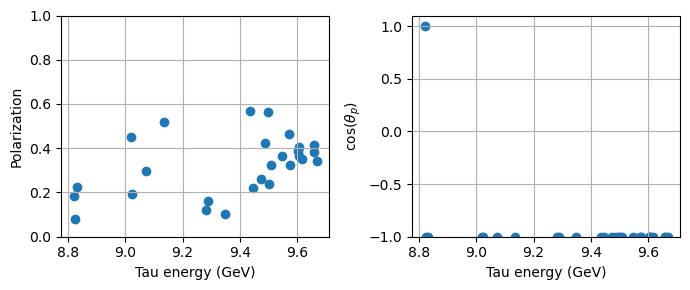

In [52]:
zero_angle_tau_events = ((tau_angles * 180/np.pi) < 0.5) & (np.abs(10 - nutau4m_rotated.E) < 0.1)

s = np.array(spin_vector(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "res_sig",
    x=res_events[zero_angle_tau_events.values]["xs"].values,
    W=res_events[zero_angle_tau_events.values]["Ws"].values,
    pdfvalues=res_events.loc[zero_angle_tau_events.values, "sigmm":"sigpp"],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot looks strange but the other plots look good.

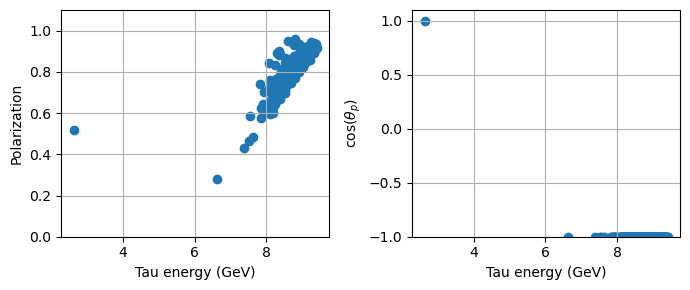

In [65]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.1
s = np.array(spin_vector(
    tau4m_rotated[almost5deg_tau_events], 
    nutau4m_rotated[almost5deg_tau_events], 
    nucleon4m_rotated[almost5deg_tau_events], 
    "res_sig",
    x=res_events[almost5deg_tau_events.values]["xs"].values,
    W=res_events[almost5deg_tau_events.values]["Ws"].values,
    pdfvalues=res_events.loc[almost5deg_tau_events.values, "sigmm":"sigpp"],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


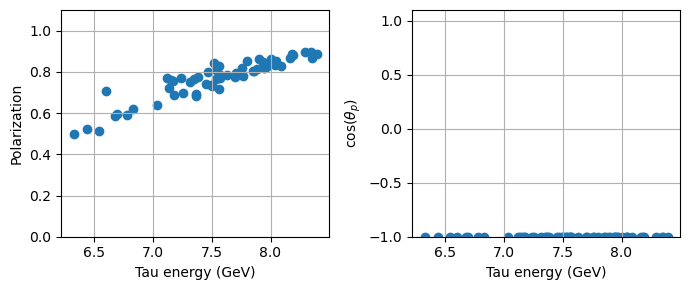

In [66]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1
s = np.array(spin_vector(
    tau4m_rotated[almost10deg_tau_events], 
    nutau4m_rotated[almost10deg_tau_events], 
    nucleon4m_rotated[almost10deg_tau_events], 
    "res_sig",
    x=res_events[almost10deg_tau_events.values]["xs"].values,
    W=res_events[almost10deg_tau_events.values]["Ws"].values,
    pdfvalues=res_events.loc[almost10deg_tau_events.values, "sigmm":"sigpp"],

))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


## Deep inelastic scattering

In [67]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]

dis_events = event_info[event_info["dis"]]

taus = dis_particles[dis_particles["pdg"] == 15]
nutaus = dis_particles.groupby("event_num").nth(1)

tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])


nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
# nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #14.895082 / 16
# nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": dis_events["En"], "px": dis_events["pxn"], "py": dis_events["pyn"], "pz": dis_events["pzn"]})
nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

pdfvalues = get_pdf_values(dis_events)

fvalues = dis_events.loc[:, "F1":"F5"]

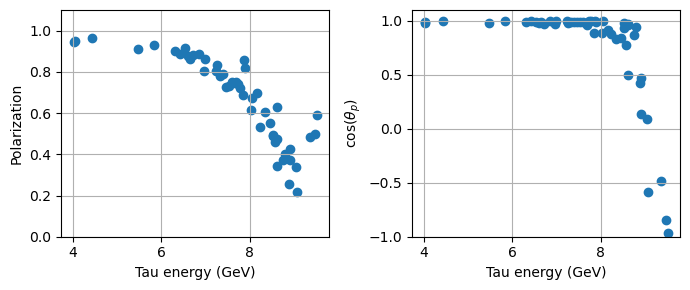

In [32]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "dis_pdf",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


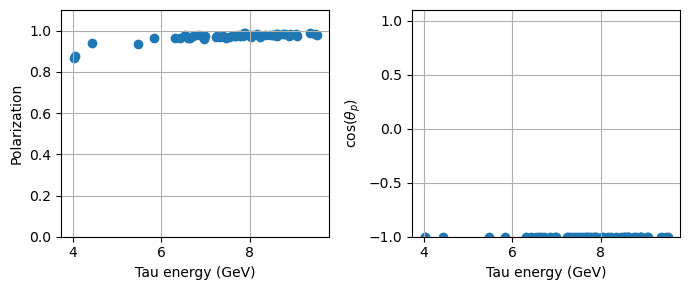

In [34]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector2(
    tau4m_rotated[zero_angle_tau_events], 
    nutau4m_rotated[zero_angle_tau_events], 
    nucleon4m_rotated[zero_angle_tau_events], 
    "dis_pdf",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like it should! See tau polarization paper, figure 6, right column

In [35]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

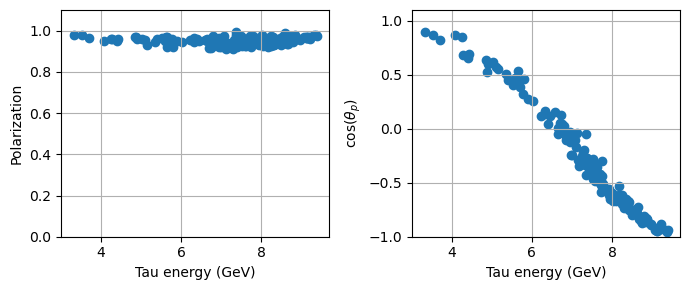

In [36]:
s = np.array(spin_vector(
    tau4m_rotated[almost5deg_tau_events], 
    nutau4m_rotated[almost5deg_tau_events], 
    nucleon4m_rotated[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["xs"].values,
    W=dis_events[almost5deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


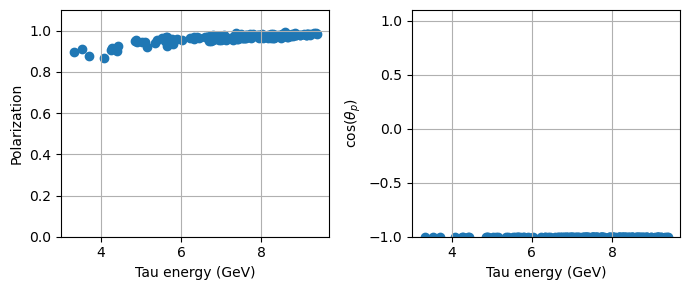

In [37]:
s = np.array(spin_vector2(
    tau4m_rotated[almost5deg_tau_events], 
    nutau4m_rotated[almost5deg_tau_events], 
    nucleon4m_rotated[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["xs"].values,
    W=dis_events[almost5deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like Figure 6, center column in the tau polarization paper

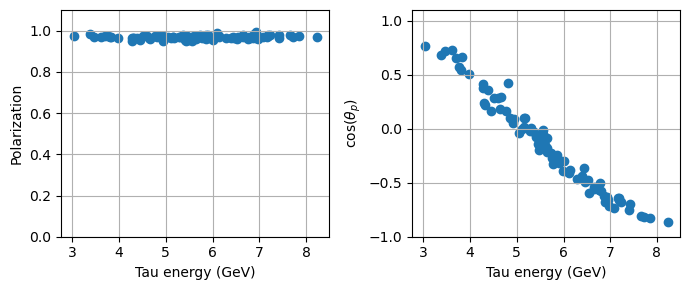

In [130]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(spin_vector(
    tau4m_rotated[almost10deg_tau_events], 
    nutau4m_rotated[almost10deg_tau_events], 
    nucleon4m_rotated[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["xs"].values,
    W=dis_events[almost10deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


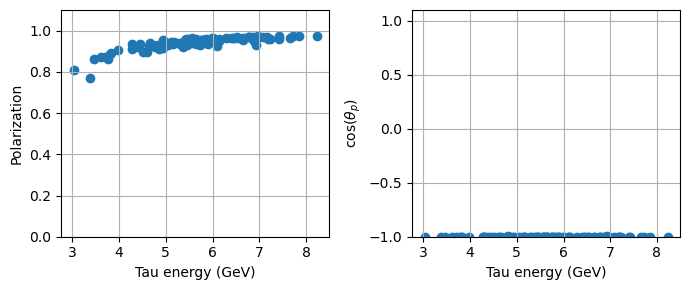

In [131]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(spin_vector2(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["xs"].values,
    W=dis_events[almost10deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot also looks exactly like it should! See tau polarization paper, figure 6, right column

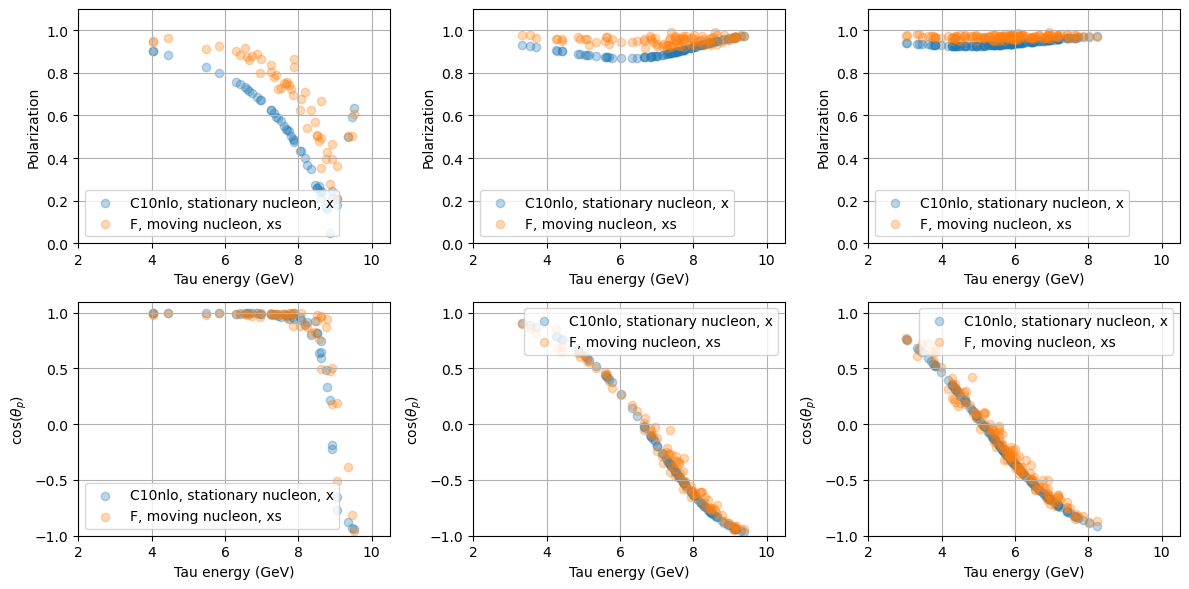

In [132]:
taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi

assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.02, 0.05)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]
    
    selected_particles = dis_particles[dis_particles["event_num"].isin(good_angle_events["event_num"])]
    selected_events = dis_events[dis_events["event_num"].isin(good_angle_events["event_num"])]
    
    selected_taus = selected_particles[selected_particles["pdg"] == 15]
    selected_nus = selected_particles.groupby("event_num").nth(1)
    
    tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
    nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
    
    nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})

    nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})
    
    nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

    selected_pdfvalues = pdfvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]
    selected_fvalues = fvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]

    for int_type, df, t4m, nu4m, nuc4m, x, label in (
        ("dis_pdf", None, tau4m, nutau4m, nucleon4m_stationary, selected_events["x"].values, "C10nlo, stationary nucleon, x"), 
        # ("dis_grv", selected_pdfvalues, nucleon4m_stationary, selected_events["x"].values, "GRV98lo, stationary nucleon, x"), 
        ("dis_f", selected_fvalues, tau4m_rotated, nutau4m_rotated, nucleon4m_rotated, selected_events["xs"].values, "F, moving nucleon, xs"),
        ):

        s = np.array(spin_vector(
            t4m, 
            nu4m,
            nuc4m,
            int_type,
            x=x,
            W=selected_events["Ws"].values,
            charm=selected_events["charm"].values,
            pdfvalues=df,
        ))

        ax_col[0].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=label, alpha=0.3)
        ax_col[1].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=label, alpha=0.3)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

## Combined plot
Plot all interaction types for the three different angles.

This is a recreation of Figure 6 in the tau polarization paper

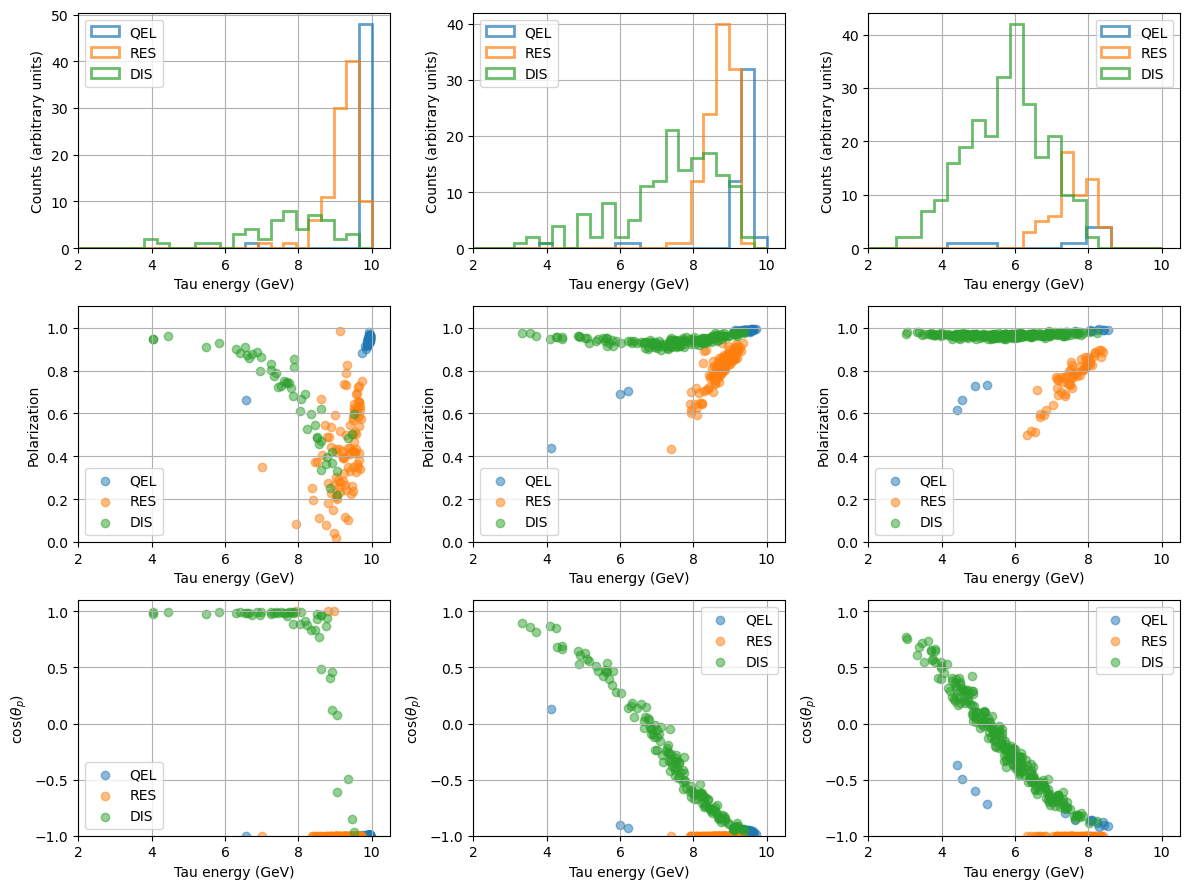

In [33]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
dis_events = event_info[event_info["dis"]]
pdfvalues = get_pdf_values(dis_events)

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, events, int_type, label, color in (
        (qel_particles, qel_events, "qel", "QEL", mpl.colormaps["tab10"](0)), 
        (res_particles, res_events, "res_sig", "RES", mpl.colormaps["tab10"](1)), 
        (dis_particles, dis_events, "dis_grv", "DIS", mpl.colormaps["tab10"](2)),
        ):
        selected_particles = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_events = events[events["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_particles[selected_particles["pdg"] == 15]
        selected_nus = selected_particles.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
        
        nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m, test=True)

        # nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})
        # nucleus = selected_particles.groupby("event_num").first()
        # nucleon4m = vector.array({"E": nucleus["E"], "px": nucleus["px"], "py": nucleus["py"], "pz": nucleus["pz"]})
        selected_fvalues = None

        if int_type == "dis_f":
            selected_fvalues = selected_events.loc[:, "F1":"F5"]
        if int_type == "dis_grv":
            selected_fvalues = get_pdf_values(selected_events)
        if int_type == "res_sig":
            selected_fvalues = selected_events.loc[:, "sigmm":"sigpp"]
        # print(int_type)
        s = np.array(spin_vector(
            tau4m_rotated, 
            nutau4m_rotated,
            nucleon4m_rotated,
            int_type,
            x=selected_events["xs"].values,
            W=selected_events["Ws"].values,
            charm=selected_events["charm"].values,
            pdfvalues=selected_fvalues,
        ))
        if np.isnan(s).any():
            print(f"NaN: {angle=}, {int_type=}", np.isnan(s).sum(axis=1))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=label, lw=2, alpha=0.7, color=color)
        ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=label, alpha=0.5, color=color)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=label, alpha=0.5, color=color)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

# fig.suptitle("Using nucleon 4-momentum")

## Change all polarization vectors for IceCube events

Incoming neutrino energy: 5 GeV
Fraction of events with norm > 1: 0.0
Incoming neutrino energy: 10 GeV
Fraction of events with norm > 1: 0.0
Incoming neutrino energy: 20 GeV
Fraction of events with norm > 1: 0.0
Incoming neutrino energy: 50 GeV
76 events are not qel, res or dis
Fraction of events with norm > 1: 0.0
Incoming neutrino energy: 100 GeV
55 events are not qel, res or dis
Fraction of events with norm > 1: 0.0


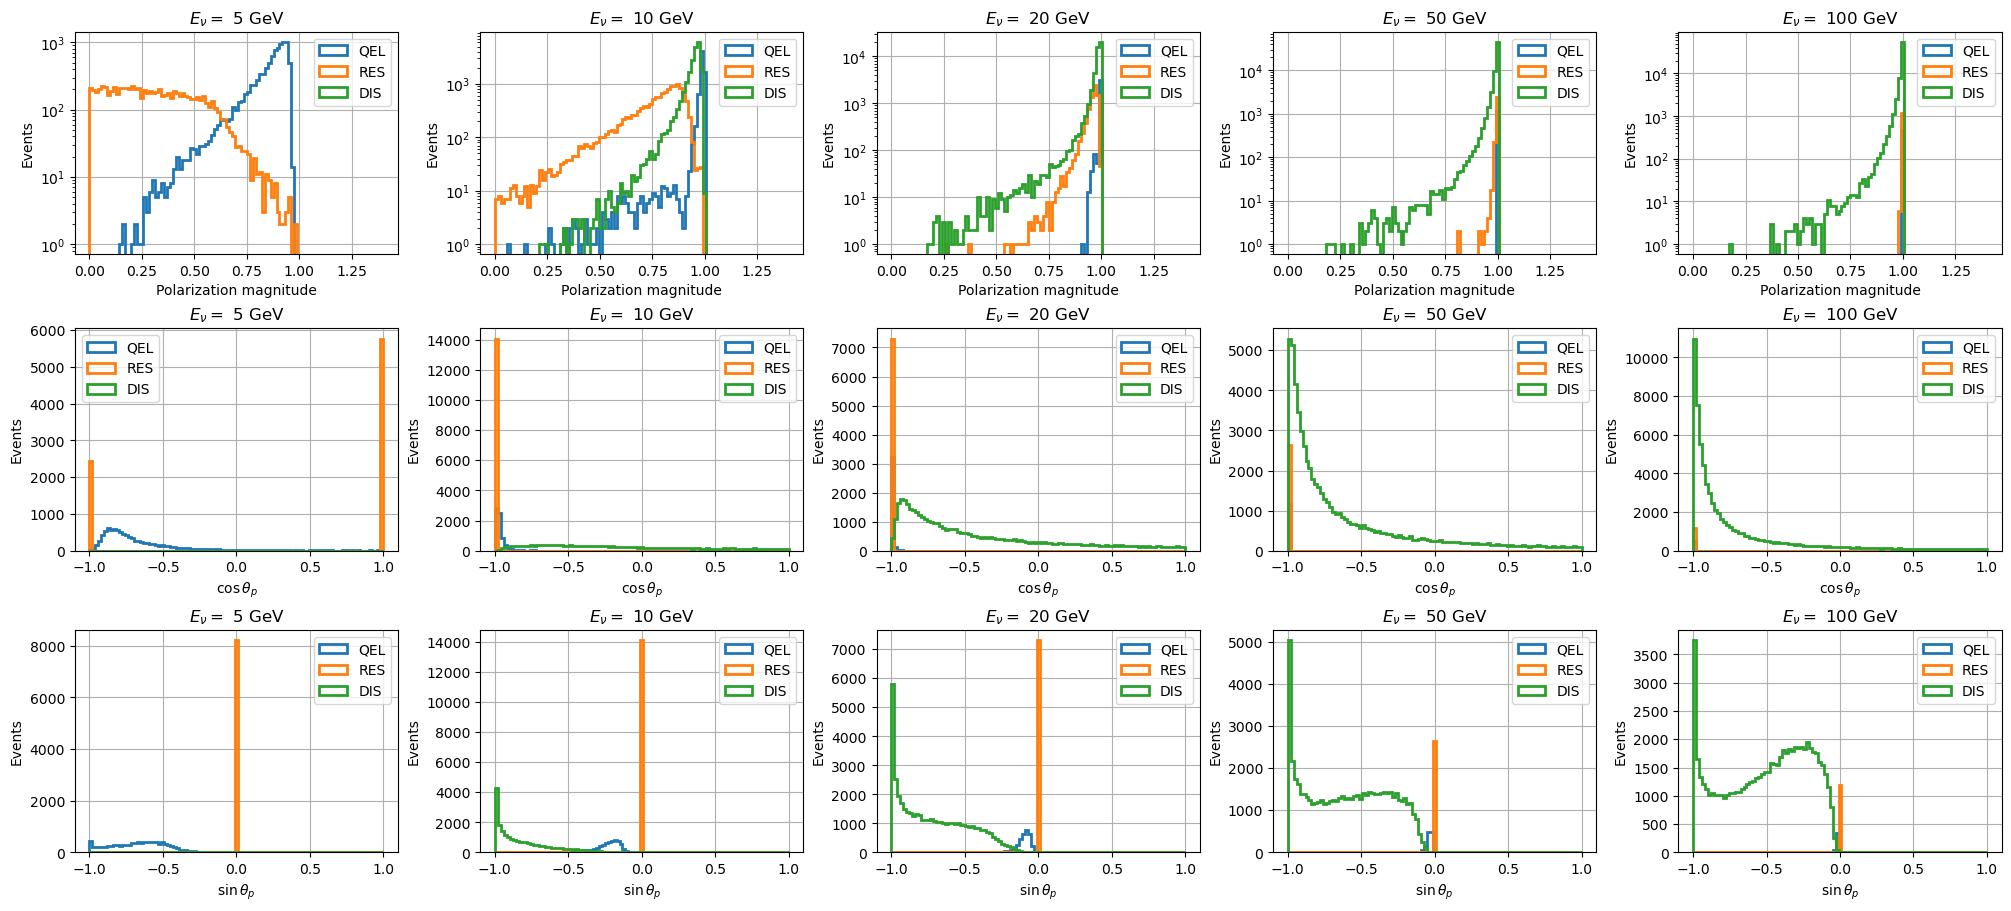

In [11]:
neutrino_energies = (5, 10, 20, 50, 100)
# Assume that the nucleon is stationary. This is an approximation that makes the polarizatio get the correct normalization.
# NOTE only works for dis_pdf, no other DIS settings
stationary = False

all_pols = {}
all_event_infos = {}

fig, axs = plt.subplots(nrows=3, ncols=len(neutrino_energies), figsize=(4*len(neutrino_energies), 9), layout="constrained")

for e, ax_col in zip(neutrino_energies, axs.T):
    # Load files
    particle_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv")
    event_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info_sig.csv")
    all_event_infos[e] = event_info
    
    pols = pd.DataFrame() # columns=["polx", "poly", "polz", "event_num"]
    # TODO make this work with dis_f, not just dis_grv and dis_pdf
    for int_type, color in (
        ("qel", mpl.colormaps["tab10"](0)),
        ("res_sig", mpl.colormaps["tab10"](1)),
        ("dis_grv", mpl.colormaps["tab10"](2))
        ):
        # Select qel, res and dis particles
        if int_type.find("_") != -1:
            int_type_col = int_type.split("_")[0]
        else:
            int_type_col = int_type

        events = event_info[event_info[int_type_col]]

        particles = particle_info[
            particle_info["event_num"]
            .isin(events.loc[events[int_type_col], "event_num"].values)
        ]

        selected_taus = particles[particles["pdg"] == 15]
        selected_nus = particles.groupby("event_num").nth(1)

        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})

        if stationary:
            x = events["x"].values
            W = events["W"].values
            nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(events.shape[0]), "py": np.zeros(events.shape[0]), "pz": np.zeros(events.shape[0])})
        else:
            x = events["xs"].values
            W = events["Ws"].values
            nucleon4m = vector.array({"E": events["En"], "px": events["pxn"], "py": events["pyn"], "pz": events["pzn"]})
        
        df = None
        if int_type == "dis_f":
            df = events.loc[:, "F1":"F5"]
        elif int_type == "dis_grv":
            df = get_pdf_values(events)
        elif int_type == "res_sig":
            df = events.loc[:, "sigmm":"sigpp"]
        
        # Rotate all vectors such that the nucleon is at rest
        nutau4m_rotated, nucleon4m_rotated, tau4m_rotated = boost_rotated_4m(nutau4m, nucleon4m, tau4m)

        s = np.array(spin_vector(
            tau4m_rotated,
            nutau4m_rotated,
            nucleon4m_rotated,
            int_type,
            x=x,
            W=W,
            charm=events["charm"].values,
            pdfvalues=df,
        ))

        p = 2 * np.linalg.norm(s, axis=0)
        # Set maximum polarization to 1
        # ax_col[0].hist(p, bins=np.linspace(0, 2, 100), label=int_type, alpha=0.3)
        # ax_col[1].hist(s[1] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type, alpha=0.3)
        ax_col[0].hist(p, bins=np.linspace(0, 1.4, 100), label=int_type_col.upper(), histtype="step", linewidth=2, color=color)
        ax_col[1].hist(s[1] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type_col.upper(), histtype="step", linewidth=2, color=color)
        ax_col[2].hist(s[0] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type_col.upper(), histtype="step", linewidth=2, color=color)
        # Transfer the polarization vector to the lab frame
        # s[1] should be along the tau momentum direction.
        # Project the first component of the polarization vector onto the plane of the tau lepton and the neutrino
        # The second component should be in the tau neutrino-tau lepton plane, orthogonal to the tau and the tau-tau neutrino plane normal
        pol_l = vector.MomentumNumpy3D(tau4m) * 2 * s[1] / tau4m.p
        transverse_direction = vector.MomentumNumpy3D(nutau4m).cross(vector.MomentumNumpy3D(tau4m)).cross(vector.MomentumNumpy3D(tau4m))
        pol_t = transverse_direction * 2 * s[0] / transverse_direction.p
        pol_vec = pol_l + pol_t
        # Check that the longitudinal and transverse components are orthogonal
        assert np.allclose(pol_l.dot(pol_t), 0)
        # Check that the angle between the tau momentum and the polarization vector is the same as theta_p
        close_angles = np.isclose(tau4m.deltaangle(pol_vec), np.arccos(s[1] / np.linalg.norm(s, axis=0)))
        assert np.all(close_angles | (s[0] == 0)), (tau4m.deltaangle(pol_vec)[~close_angles], np.arccos(s[1] / np.linalg.norm(s, axis=0))[~close_angles])

        new_pols = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": pol_vec.px, "poly": pol_vec.py, "polz": pol_vec.pz})
        
        # Concatenate the data with the pols dataframe
        pols = pd.concat([pols, new_pols])
    
    # Fill in the missing polarizations with 0, i.e. assume that they are unpolarized.
    events_not_in_pols = event_info.loc[~event_info["event_num"].isin(pols["event_num"].values), "event_num"].unique()
    
    # TODO for other interactions (which in practice is just coherent scattering), we assume unpolarized (or fully left-handed is a better approximation perhaps?)
    pols = pd.concat([pols, pd.DataFrame({"event_num": events_not_in_pols, "polx": np.zeros(events_not_in_pols.shape[0]), "poly": np.zeros(events_not_in_pols.shape[0]), "polz": np.zeros(events_not_in_pols.shape[0])})])
    print(f"Incoming neutrino energy: {e} GeV")
    if events_not_in_pols.shape[0] > 0:
        print(events_not_in_pols.shape[0], "events are not qel, res or dis")
    
    print("Fraction of events with norm > 1:", (np.linalg.norm(pols[["polx", "poly", "polz"]], axis=1) > 1).sum() / pols.shape[0])
    
    # Fill up nan values. In practice, this should never happen
    if pols["polz"].isnull().any():
        print("Number of NaN values:", pols["polz"].isnull().sum())
        pols = pols.fillna(0)
        
    pols = pols.sort_values("event_num")
    
    all_pols[e] = pols

    # uncomment this once I am confident that the code works
    # pols.to_csv(f"../data/NuTau_{e}.0_GeV_tau-b.csv", index=False)

    ax_col[0].set(title=r"$E_\nu=$ " + f"{e} GeV", xlabel="Polarization magnitude", ylabel="Events", yscale="log",
    )
    ax_col[1].set(title=r"$E_\nu=$ " + f"{e} GeV", xlabel=r"$\cos\theta_p$", ylabel="Events")
    ax_col[2].set(title=r"$E_\nu=$ " + f"{e} GeV", xlabel=r"$\sin\theta_p$", ylabel="Events")
    
for ax in axs.flat:
    ax.grid(True)
    ax.legend()

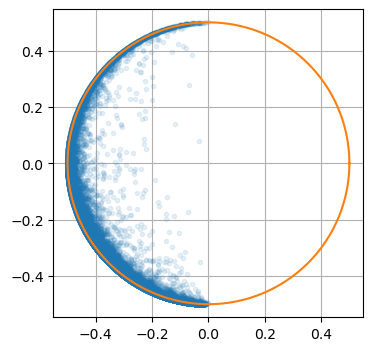

In [21]:
# Plot the s[0] and s[1] distributions
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(s[0, :], s[1, :], ".", alpha=0.1)
ax.grid(True)
ax.axis("equal")
theta = np.linspace(0, 2*np.pi, 1000)
ax.plot(np.cos(theta)/2, np.sin(theta)/2)

## Compare the F values from the GENIE implementation and my copied code

In [22]:
event_info_int = pd.read_csv(f"../data/test_genie_NuTau_100.0_GeV_event_info_f_int.csv")
event_info = pd.read_csv(f"../data/test_genie_NuTau_100.0_GeV_event_info_f.csv")

In [23]:
event_info_int

,event_num,cc,dis,qel,res,nuel,coh,dfr,imd,xsec,...,Mnuc,Enu,pxnu,pynu,pznu,F1,F2,F3,F4,F5
0,0,True,True,False,False,False,False,False,False,466.961382,...,0.912346,100.0,0.0,0.0,100.0,0.951793,0.705959,1.943070,0.0,1.943070
1,1,True,True,False,False,False,False,False,False,466.961382,...,0.911133,100.0,0.0,0.0,100.0,0.948469,0.720320,1.939420,0.0,1.939420
2,2,True,True,False,False,False,False,False,False,193.725871,...,0.909514,100.0,0.0,0.0,100.0,0.192452,0.172226,0.390341,0.0,0.390341
3,3,True,True,False,False,False,False,False,False,193.725871,...,0.901039,100.0,0.0,0.0,100.0,2.238550,0.522559,5.058310,0.0,5.058310
4,4,True,True,False,False,False,False,False,False,24.925484,...,0.900113,100.0,0.0,0.0,100.0,2.396390,1.156180,5.227730,0.0,5.227730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70087,70088,True,True,False,False,False,False,False,False,466.961382,...,0.895803,100.0,0.0,0.0,100.0,1.922760,1.109620,4.168640,0.0,4.168640
70088,70089,True,True,False,False,False,False,False,False,41.312172,...,0.907906,100.0,0.0,0.0,100.0,0.374387,0.153171,0.865790,0.0,0.865790
70089,70090,True,True,False,False,False,False,False,False,466.961382,...,0.914144,100.0,0.0,0.0,100.0,1.632950,0.953482,3.376450,0.0,3.376450
70090,70091,True,True,False,False,False,False,False,False,14.844421,...,0.889025,100.0,0.0,0.0,100.0,0.678351,0.215590,-1.546020,0.0,1.546020


In [24]:
event_info

,event_num,cc,dis,qel,res,nuel,coh,dfr,imd,xsec,...,Mnuc,Enu,pxnu,pynu,pznu,F1,F2,F3,F4,F5
0,0,True,True,False,False,False,False,False,False,466.961382,...,0.912346,100.0,0.0,0.0,100.0,0.952182,0.706247,1.943870,0.0,1.943870
1,1,True,True,False,False,False,False,False,False,466.961382,...,0.911133,100.0,0.0,0.0,100.0,0.949203,0.720878,1.940920,0.0,1.940920
2,2,True,True,False,False,False,False,False,False,193.725871,...,0.909514,100.0,0.0,0.0,100.0,0.192637,0.172391,0.390715,0.0,0.390715
3,3,True,True,False,False,False,False,False,False,193.725871,...,0.901039,100.0,0.0,0.0,100.0,2.238060,0.522445,5.057210,0.0,5.057210
4,4,True,True,False,False,False,False,False,False,24.925484,...,0.900113,100.0,0.0,0.0,100.0,2.398640,1.157270,5.232660,0.0,5.232660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70087,70088,True,True,False,False,False,False,False,False,466.961382,...,0.895803,100.0,0.0,0.0,100.0,1.927410,1.112310,4.178730,0.0,4.178730
70088,70089,True,True,False,False,False,False,False,False,41.312172,...,0.907906,100.0,0.0,0.0,100.0,0.376126,0.153883,0.869812,0.0,0.869812
70089,70090,True,True,False,False,False,False,False,False,466.961382,...,0.914144,100.0,0.0,0.0,100.0,1.633500,0.953802,3.377580,0.0,3.377580
70090,70091,True,True,False,False,False,False,False,False,14.844421,...,0.889025,100.0,0.0,0.0,100.0,0.678351,0.215590,-1.546020,0.0,1.546020


In [25]:
np.isclose(event_info.loc[event_info["dis"], "F1":"F5"], event_info_int.loc[event_info_int["dis"], "F1":"F5"], atol=1e-4).sum(axis=0)

array([10143, 13313,  8235, 68379,  8235])

## Plot GRV98LO PDF

In [26]:
pdf = pd.read_csv("../data/grv98lo_eval.csv")
bypdf = pd.read_csv("../data/bypdf.csv")

<Axes: xlabel='x', ylabel='PDF'>

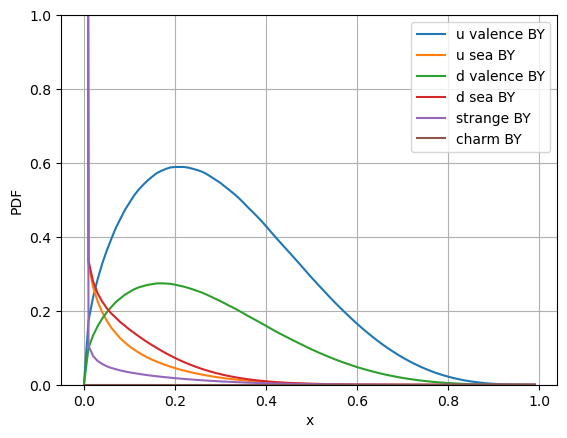

In [12]:
fig, ax = plt.subplots()

# Get the first 6 colors from the default line color sequence
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]

# pdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], color=colors, ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], ylabel="PDF", grid=True, alpha=0.7, ax=ax)
bypdf.plot(
    x="x", 
    y=["fuv", "fus", "fdv", "fds", "fs", "fc"], 
    color=colors, 
    # ls="dashed", 
    ylim=(0, 1), 
    label=["u valence BY", "u sea BY", "d valence BY", "d sea BY", "strange BY", "charm BY"], 
    ylabel="PDF", 
    grid=True, 
    # alpha=0.7, 
    ax=ax
)

Text(1, 0.5, '$Q^2 = 5$ GeV$^2$')

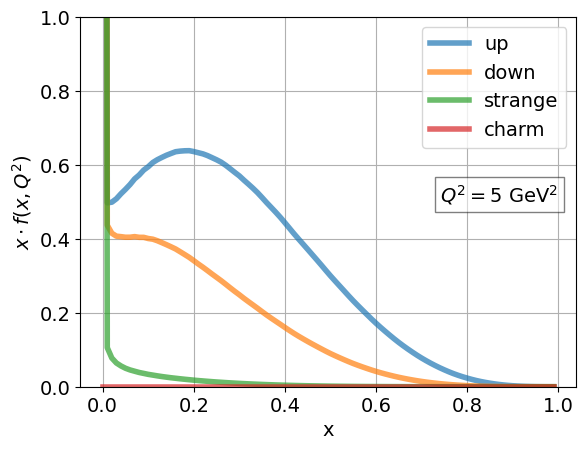

In [27]:
fig, ax = plt.subplots()
# Set font size of figure to 12
plt.rcParams.update({'font.size': 14})

# Get the first 6 colors from the default line color sequence
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]
pdf["up"] = (pdf["fuv"] + pdf["fus"])# / pdf["x"]
pdf["down"] = pdf["fdv"] + pdf["fds"]# / pdf["x"]
pdf["strange"] = pdf["fs"]# / pdf["x"]
pdf["charm"] = pdf["fc"]# / pdf["x"]
pdf.plot(
    x="x", 
    y=["up", "down", "strange", "charm"], 
    color=colors, 
    ylim=(0, 1), 
    # label=["u valence BY", "u sea BY", "d valence BY", "d sea BY", "strange BY", "charm BY"], 
    ylabel=r"$x\cdot f(x, Q^2)$", 
    grid=True, 
    linewidth=4,
    alpha=0.7, 
    ax=ax
)
# Write $Q^2 = 5$ GeV$^2$ in the center right of the plot
ax.text(1, 0.5, "$Q^2 = 5$ GeV$^2$", fontsize=14, ha="right", bbox=dict(facecolor='white', alpha=0.5))

<Axes: xlabel='x', ylabel='x*PDF'>

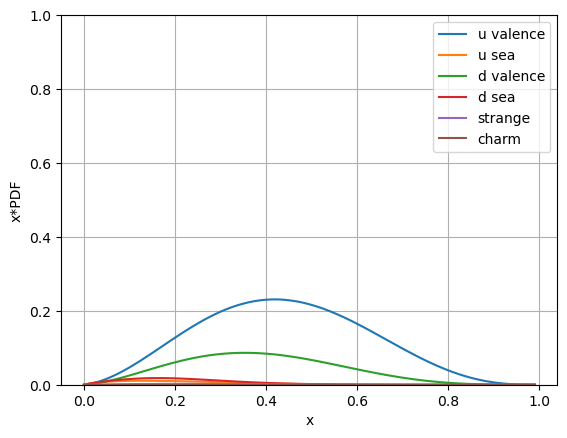

In [246]:
xpdf = pdf.copy()
xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] = xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] * xpdf["x"].values[:, np.newaxis]
xpdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], grid=True, ylabel="x*PDF")

# Test different x and y polarizations
This is to determine how these components affect the decays, or if they have any effect at all.

In [7]:
import sys
sys.path.append("../")
from utils import load_hepmc

In [ ]:
# Write events
e = 5

# Load files
particle_info = pd.read_csv(f"../data/test_bare_lepton_toy_Tau_000005_{e}.0_GeV_particles_extended.csv")

selected_taus = particle_info[particle_info["pdg"] == 15]
selected_nus = particle_info.groupby("event_num").nth(1)
nevents = selected_taus["event_num"].shape[0]
pols = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": np.zeros(nevents), "poly": -0.5 * np.ones(nevents), "polz": -np.sqrt(1 - 0.5**2) * np.ones(nevents)})
pols2 = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": -0.5 * np.ones(nevents), "poly": np.zeros(nevents), "polz": -np.sqrt(1 - 0.5**2) * np.ones(nevents)})
pols3 = pd.DataFrame({"event_num": selected_taus["event_num"], "polx": np.zeros(nevents), "poly": np.zeros(nevents), "polz": -np.ones(nevents)})

pols.to_csv(f"../data/test_pol_{e}.0_GeV_1.csv", index=False)
pols2.to_csv(f"../data/test_pol_{e}.0_GeV_2.csv", index=False)
pols3.to_csv(f"../data/test_pol_{e}.0_GeV_3.csv", index=False)

In [8]:
# Load simulated decays events
poly = load_hepmc(f"../data/test_pol_{e}.0_GeV_1.dat")
polx = load_hepmc(f"../data/test_pol_{e}.0_GeV_2.dat")
polz = load_hepmc(f"../data/test_pol_{e}.0_GeV_3.dat")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [45]:
def tau_visible_e(df) -> np.ndarray:
    return df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)").groupby("event_num")["E"].sum()

def visible_theta(df) -> np.ndarray:
    """The angle between the combined 4-momentum of the visible particles and the z axis"""
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    p = np.sqrt(
        (
            visible_decay_products.groupby("event_num")[["px", "py", "pz"]]
            .sum() # Sum over all decay products
            **2 # Square each component
        ).sum(axis=1) # Sum over the components
    ) # Sqrt of the sum
    pz = visible_decay_products.groupby("event_num")["pz"].sum()
    return np.arccos(pz / np.sqrt(p**2))

def tau_visible_cosphi(df):
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["px", "py", "pz"]].sum() # Sum over all decay products
    return np.arccos(visible["px"] / np.sqrt(visible["px"]**2 + visible["py"]**2))

# x and y are not boosted for these taus moving in purely z direction, so this will give the same result as for the function above.
def tau_visible_cosphi_rest(df):
    taus = df[df["pdg"] == 15]
    visible_decay_products = df.groupby("event_num").nth[3:].query("(pdg.abs() != 12) and (pdg.abs() != 14) and (pdg.abs() != 16)")
    visible = visible_decay_products.groupby("event_num")[["E", "px", "py", "pz"]].sum() # Sum over all decay products
    visible4m = vector.array({"E": visible["E"], "px": visible["px"], "py": visible["py"], "pz": visible["pz"]})
    tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
    visible_boosted = visible4m.boostCM_of(tau4m)
    return np.arccos(visible_boosted["px"] / np.sqrt(visible_boosted["px"]**2 + visible_boosted["py"]**2))

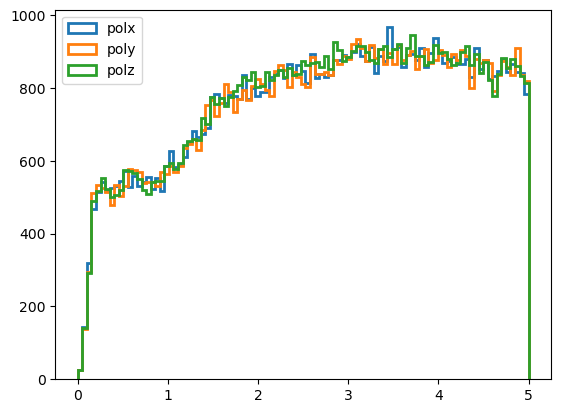

In [28]:
fig, ax = plt.subplots()
for pol, label in ((polx, "polx"), (poly, "poly"), (polz, "polz")):
    ax.hist(tau_visible_e(pol), bins=np.linspace(0, e, 100), histtype="step", label=label, lw=2)
ax.legend()

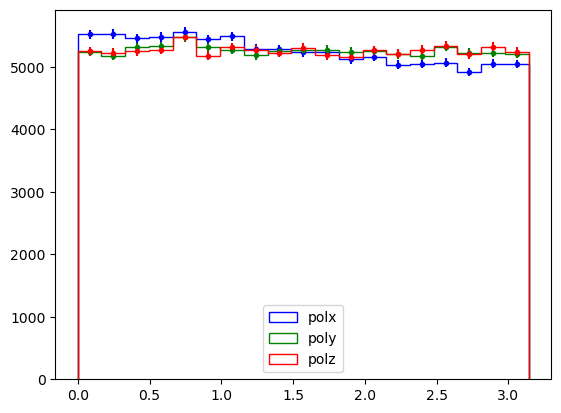

In [42]:
fig, ax = plt.subplots()
bins = np.linspace(0, np.pi, 20)
for pol, label, c in ((polx, "polx", "b"), (poly, "poly", "g"), (polz, "polz", "r")):
    values, *_ = ax.hist(tau_visible_cosphi(pol), bins=bins, histtype="step", label=label, color=c)
    ax.errorbar((bins[:-1] + bins[1:])/2, values, yerr=np.sqrt(values), fmt=".", color=c)
ax.legend()

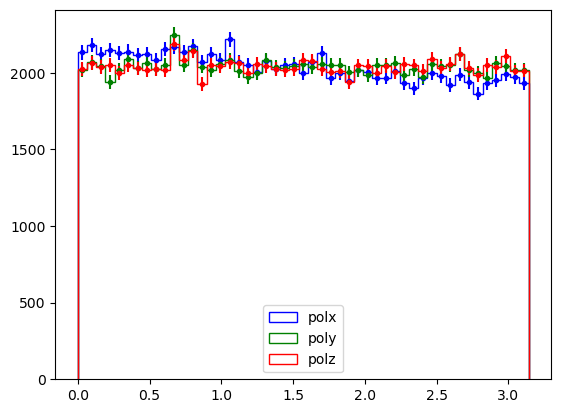

In [44]:
fig, ax = plt.subplots()
bins = np.linspace(0, np.pi, 50)
for pol, label, c in ((polx, "polx", "b"), (poly, "poly", "g"), (polz, "polz", "r")):
    values, *_ = ax.hist(tau_visible_cosphi_rest(pol), bins=bins, histtype="step", label=label, color=c)
    ax.errorbar((bins[:-1] + bins[1:])/2, values, yerr=np.sqrt(values), fmt=".", color=c)
ax.legend()

From this we can conclude that the x and y components do have an effect, albeit very small.